In [52]:
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy import stats

from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns",None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

## Data Loading

In [79]:
pcp_df = pd.read_csv("./data/power_consumption_prediction.csv")
cl_df = pd.read_csv("./data/CLdata.csv")
bs_df = pd.read_csv("./data/BSinfo.csv")
ec_df = pd.read_csv("./data/ECdata.csv")

In [80]:
pcp_df.shape , cl_df.shape , bs_df.shape , ec_df.shape

((26705, 4), (125575, 10), (1217, 8), (92629, 3))

In [6]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [7]:
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [8]:
bs_df.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [9]:
pcp_df.head()

,Time,BS,Energy,w
0,1/1/2023 6:00,B_0,NaN,1
1,1/1/2023 11:00,B_0,NaN,1
2,1/1/2023 12:00,B_0,NaN,1
3,1/1/2023 13:00,B_0,NaN,1
4,1/1/2023 23:00,B_0,NaN,1


In [10]:
# w is the weight of the particular sample while calculating the mean absolute percentage error
pcp_df['w'].value_counts()

,count
w,
1,23755
5,2950


## Data Pre-Processing

In [11]:
def rename_columns(df):
    df.rename(columns=lambda x:x.lower().replace(' ',"_"),inplace=True)

In [12]:
rename_columns(pcp_df)
rename_columns(cl_df)
rename_columns(bs_df)
rename_columns(ec_df)

In [13]:
cl_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [14]:
bs_df.head()

,bs,cellname,rutype,mode,frequency,bandwidth,antennas,txpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [15]:
ec_df.head()

,time,bs,energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [16]:
pcp_df.head()

,time,bs,energy,w
0,1/1/2023 6:00,B_0,NaN,1
1,1/1/2023 11:00,B_0,NaN,1
2,1/1/2023 12:00,B_0,NaN,1
3,1/1/2023 13:00,B_0,NaN,1
4,1/1/2023 23:00,B_0,NaN,1


Venn diagram representing the training base stations and test base stations intersection

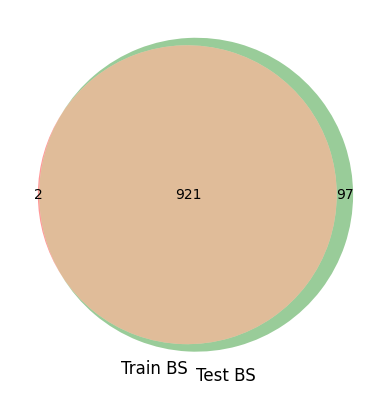

In [17]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set,test_bs_set],("Train BS", "Test BS"))
plt.show()

In [18]:
# Convert text time to pandas datetime
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [19]:
cl_bs_df = cl_df.merge(bs_df,on=['bs','cellname'],how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [20]:
# Cells whose base stations are B_0
cl_bs_df[
    cl_bs_df['bs'] == 'B_0'
 ]

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [21]:
# No of unique cells for a base station
cl_bs_df.groupby("bs")['cellname'].nunique()

,cellname
bs,
B_0,2
B_1,1
B_10,2
B_100,1
B_1000,1
...,...
B_995,1
B_996,1
B_997,1


In [22]:
# Most of the base stations has only 1 cell
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

,count
cellname,
1,827
2,191
4,2


In [23]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


Energy consumption data contains energy only from the base station but not from the cells individually. So we need to convert the energy of cells in the base station into the form of energy consumed by the base station.

In [24]:
cl_bs_df = cl_bs_df.pivot(
    index=['time','bs'],
    # Pivot column
    columns=['cellname'],
    values=[
        'load','esmode1','esmode2','esmode3',
        'esmode4','esmode5','esmode6','frequency',
        'bandwidth','antennas','txpower'
    ]
).reset_index()

cl_bs_df.columns = [ '_'.join([str(i) for i in x]) for x in cl_bs_df.columns ]
cl_bs_df.columns = cl_bs_df.columns.str.strip("_")

rename_columns(cl_bs_df)

cl_bs_df = cl_bs_df.merge(
    bs_df.groupby('bs')[['rutype','mode']].first().reset_index(),on='bs',how='left'
)

In [25]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2


In [26]:
cl_bs_df.describe()

,time,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3
count,118768,118768.000000,6711.000000,48.000000,48.000000,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.0,6711.0,48.0,48.0,118768.000000,6711.0,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,4.800000e+01,4.800000e+01,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.000000,48.000000
mean,2023-01-03 23:54:54.281287680,0.246362,0.111214,0.070212,0.081115,0.042145,0.004985,0.0,0.0,0.038640,0.003311,0.0,0.0,0.000082,0.000135,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.0,0.0,0.019168,0.386253,0.0,0.0,373.152776,379.542459,4.269800e+02,4.269800e+02,16.323740,6.338251,2.0,2.0,2.493079,2.218149,2.0,2.0,6.728786,7.028953,6.877429,6.877429
min,2023-01-01 01:00:00,0.000000,0.008190,0.045942,0.045904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,155.600000,155.600000,4.269800e+02,4.269800e+02,2.000000,2.000000,2.0,2.0,1.000000,1.000000,2.0,2.0,5.381166,6.427504,6.877429,6.877429
25%,2023-01-02 10:00:00,0.055714,0.051894,0.054442,0.051822,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,189.000000,365.000000,4.269800e+02,4.269800e+02,10.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.427504,6.761584,6.877429,6.877429
50%,2023-01-03 19:00:00,0.162470,0.079423,0.066760,0.067856,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.275973,0.0,0.0,365.000000,426.980000,4.269800e+02,4.269800e+02,20.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
75%,2023-01-05 13:00:00,0.367142,0.138202,0.079385,0.095495,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.803992,0.0,0.0,532.000000,426.980000,4.269800e+02,4.269800e+02,20.000000,10.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
max,2023-01-08 00:00:00,0.993957,0.891770,0.174846,0.196519,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.154563,0.062805,0.0,0.0,0.0,0.0,0.0,0.0,0.768070,0.0,0.0,0.0,0.931032,0.927924,0.0,0.0,979.998000,697.002000,4.269800e+02,4.269800e+02,20.000000,20.000000,2.0,2.0,64.000000,8.000000,2.0,2.0,8.375336,7.877728,6.877429,6.877429
std,NaN,0.239354,0.091569,0.023807,0.038373,0.194184,0.064911,0.0,0.0,0.186785,0.052831,0.0,0.0,0.002439,0.002422,0.0,0.0,0.0,0.0,0.0,0.0,0.002882,0.0,0.0,0.0,0.112214,0.395205,0.0,0.0,145.409519,102.348829,2.872248e-13,2.872248e-13,5.238965,6.209317,0.0,0.0,4.617650,0.755766,0.0,0.0,0.330830,0.386024,0.000000,0.000000


In [27]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [28]:
df = cl_bs_df.merge(ec_df,on=['time','bs'],how='left')

In [29]:
df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590


## Exploratory Data Analysis

In [30]:
df['energy'].describe()

,energy
count,92629.000000
mean,28.138997
std,13.934645
min,0.747384
25%,18.236173
50%,24.065770
75%,35.724963
max,100.000000


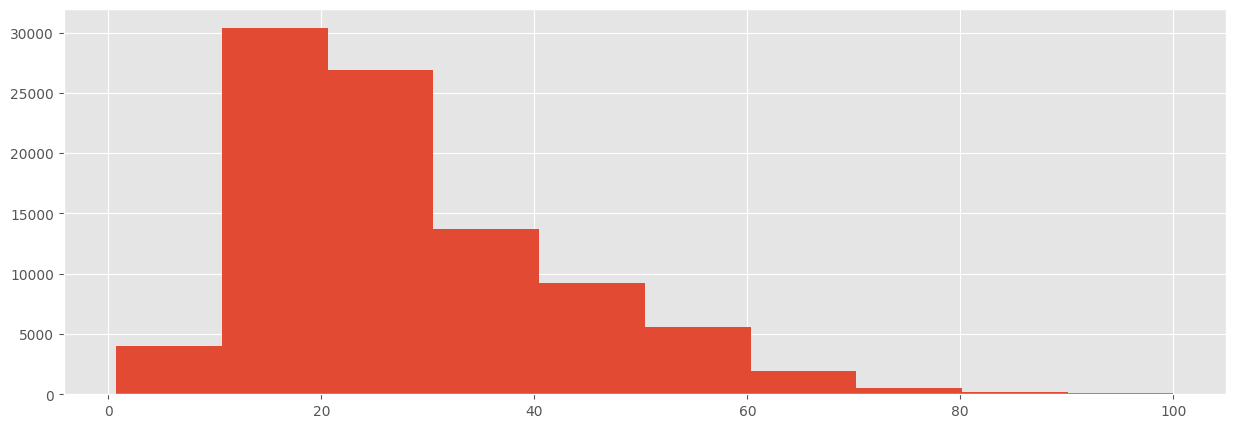

In [31]:
# The Data is Right skewed
plt.figure(figsize=(15,5))
df['energy'].hist()
plt.show()

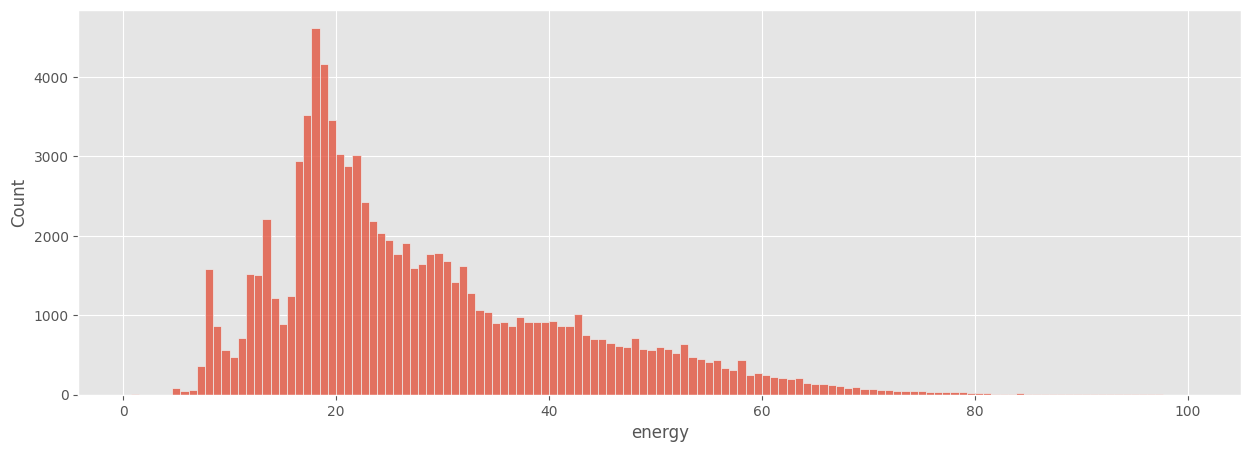

In [32]:
plt.figure(figsize=(15,5))
sns.histplot(df['energy'])
plt.show()

Energy consumption based on time - energy is more consumed during day time and less during nights

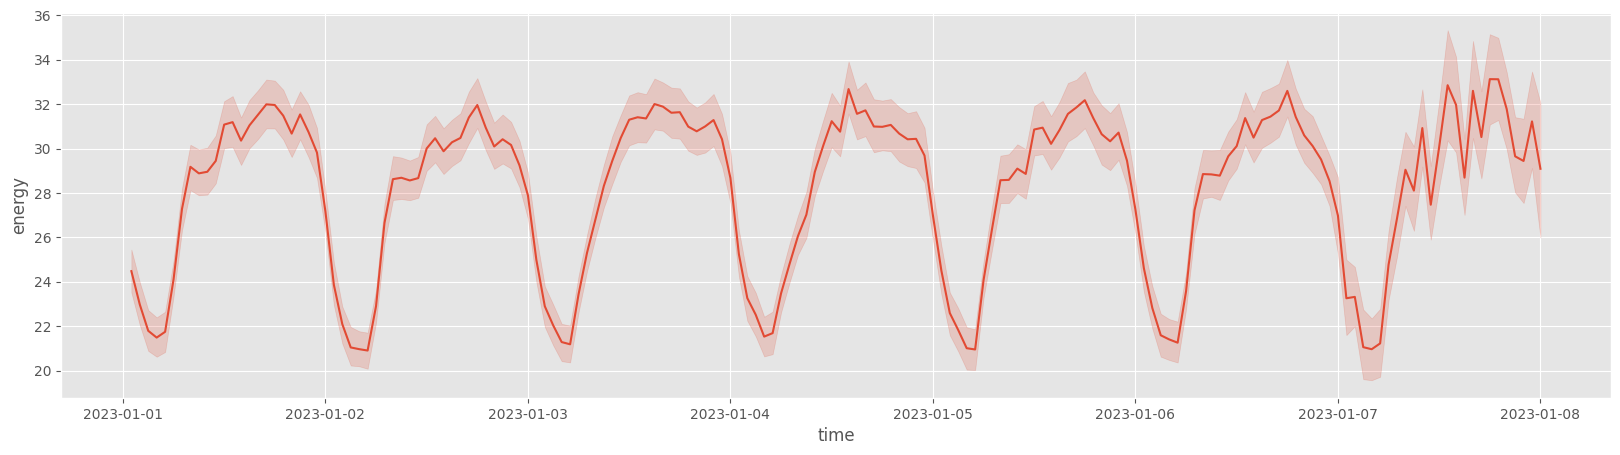

In [33]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df,x='time',y='energy')
plt.show()

Energy consumption based on time and the rutype of base station - Type1 base stations are consuming more energy

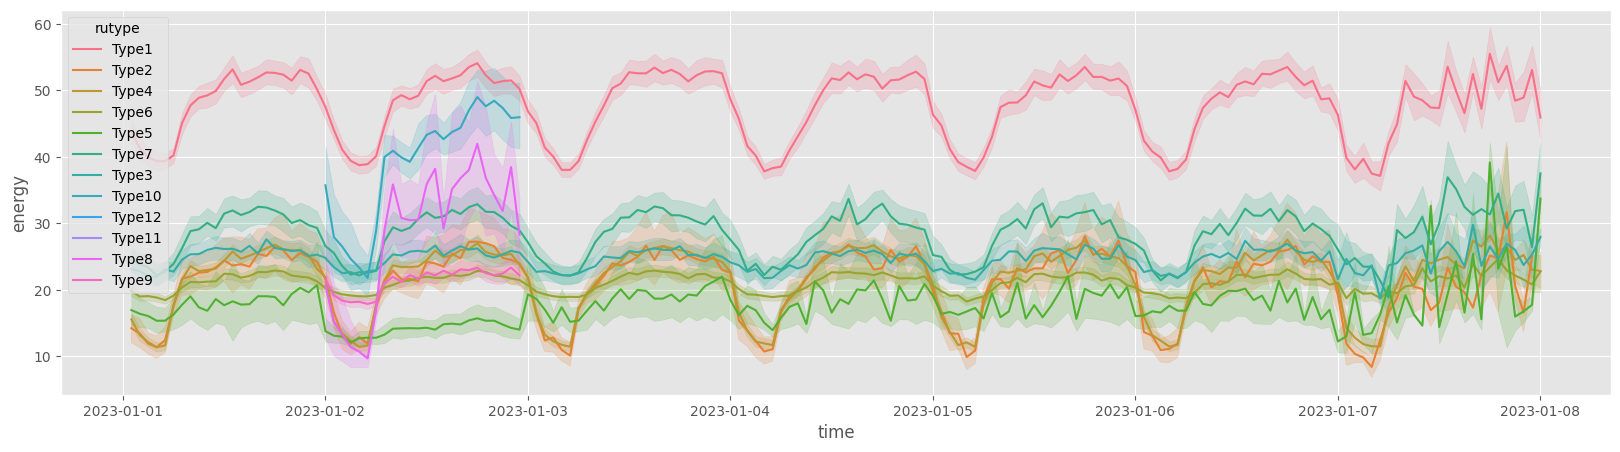

In [34]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df,x='time',y='energy',hue='rutype')
plt.show()

Energy consumption based on time and the mode of base station

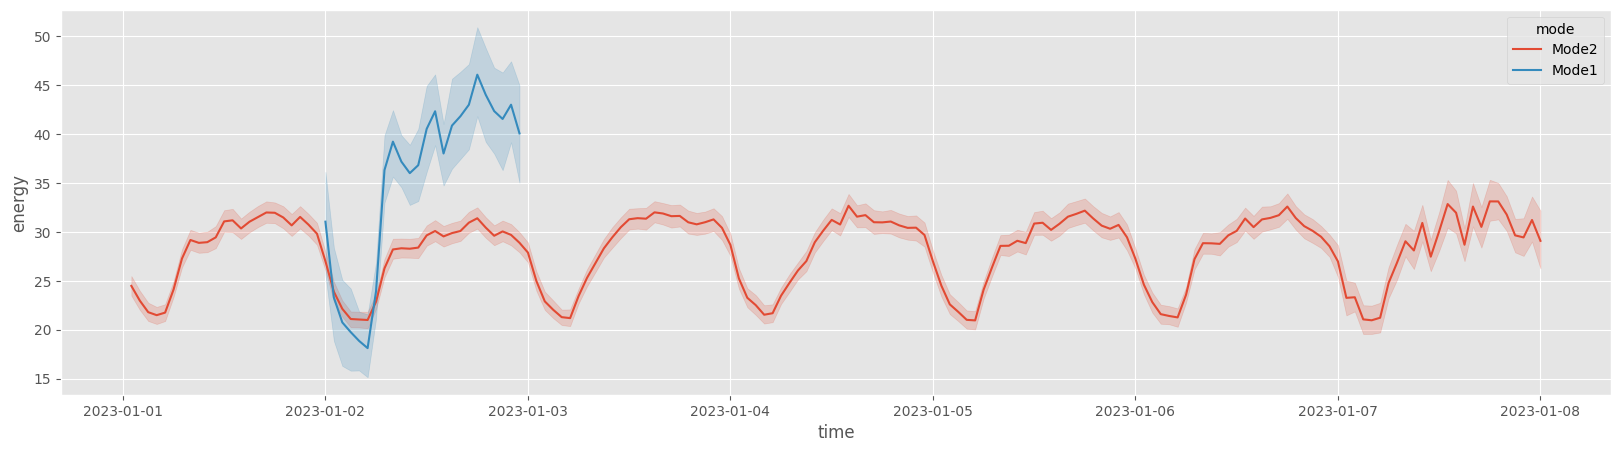

In [35]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df,x='time',y='energy',hue='mode')
plt.show()

Energy consumption based on time and the antennas of cell types in the base station - increase in no of antennas increases the energy consumption

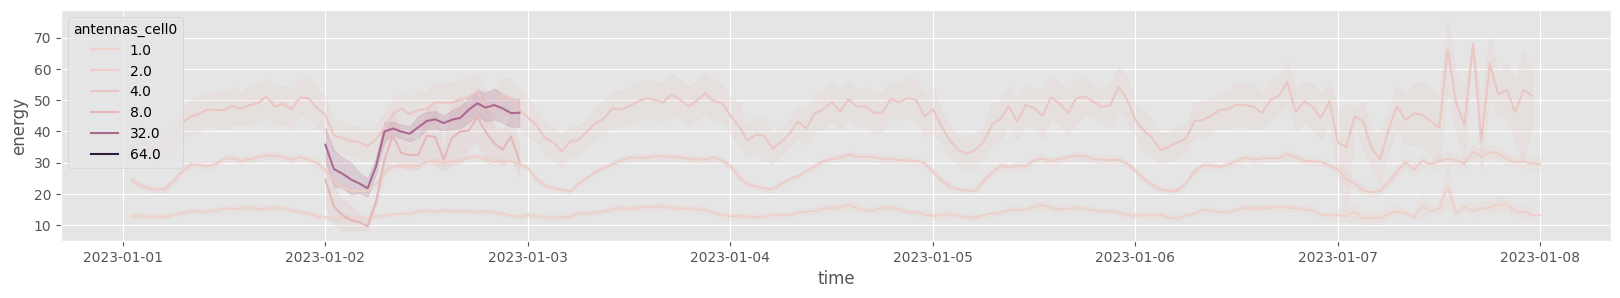

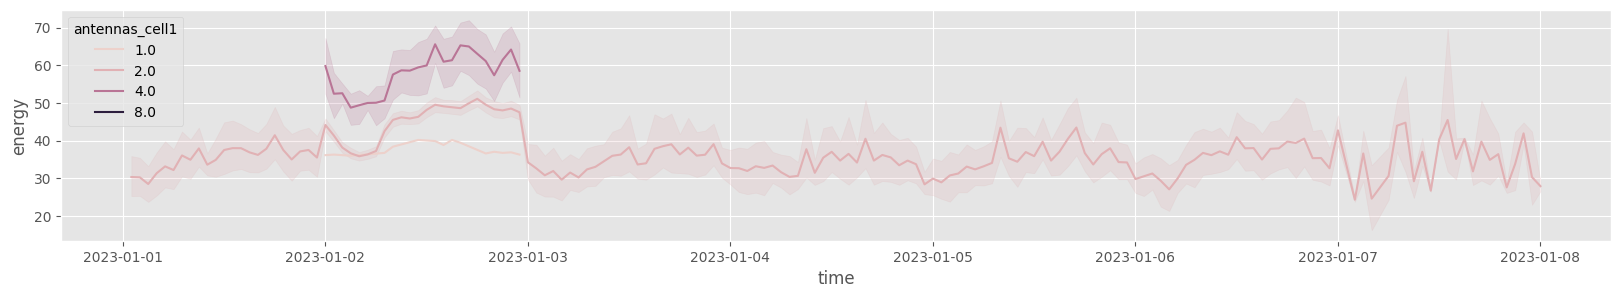

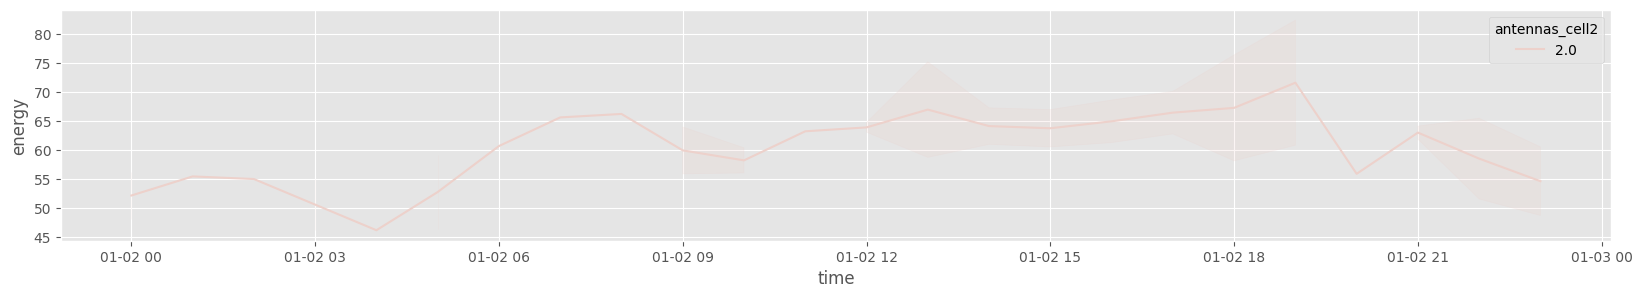

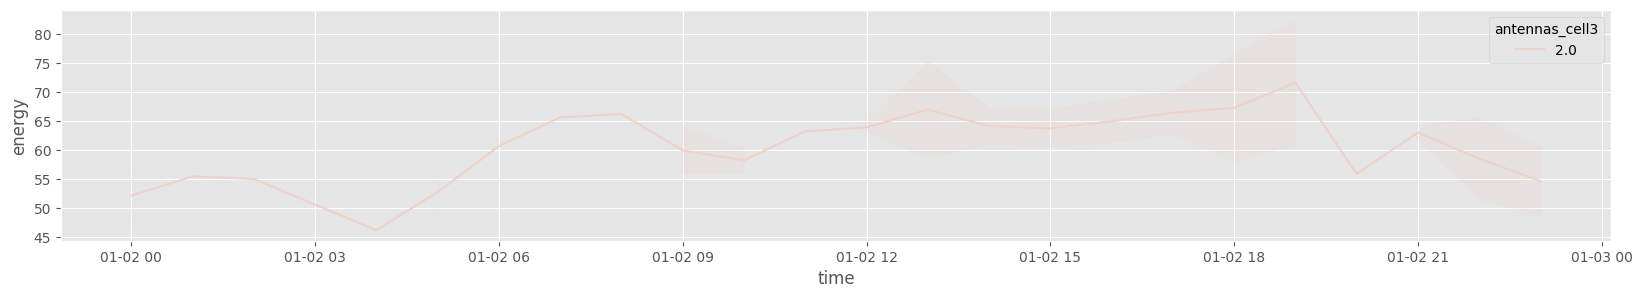

In [36]:
plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='antennas_cell3')
plt.show()

Energy consumption based on time and the bandwidth of a cell in the base station - increase in bandwidth of a cell increases the energy consumption

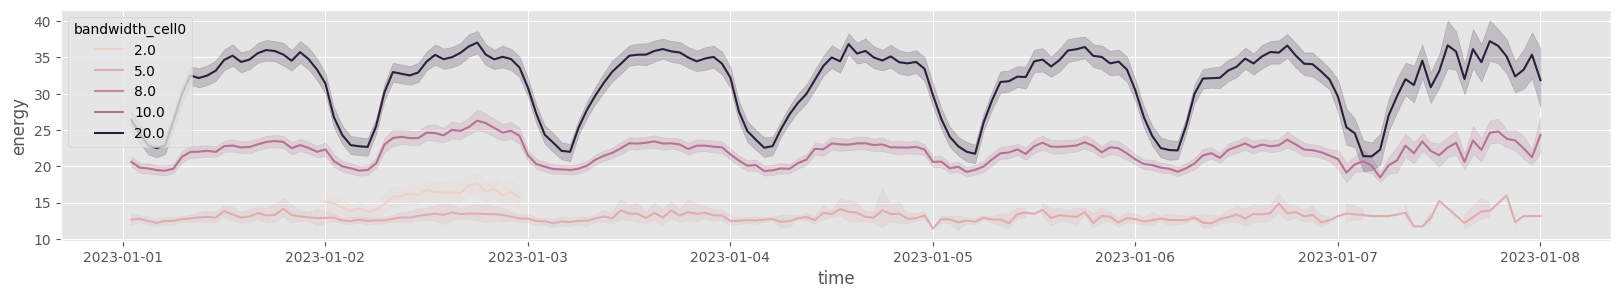

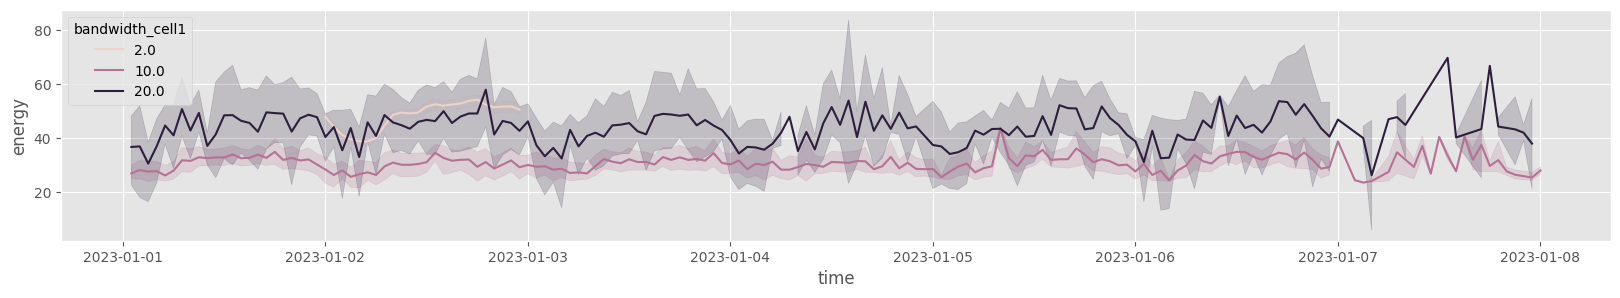

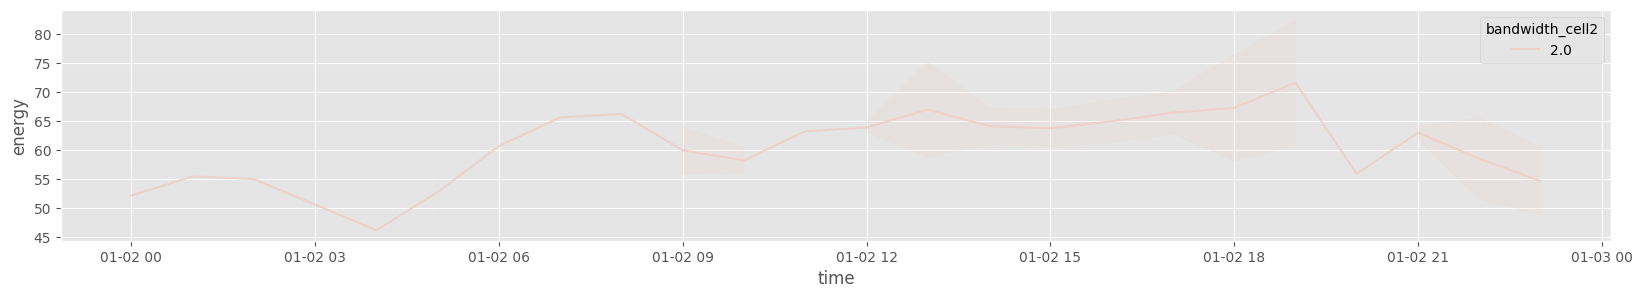

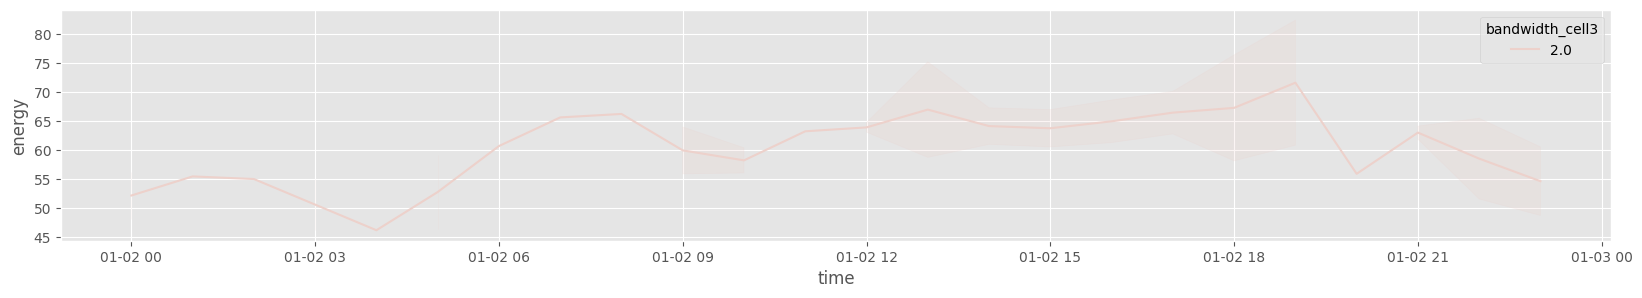

In [37]:
plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20,3))
sns.lineplot(data=df,x='time',y='energy',hue='bandwidth_cell3')
plt.show()

Energy consumption comparision to all the products used

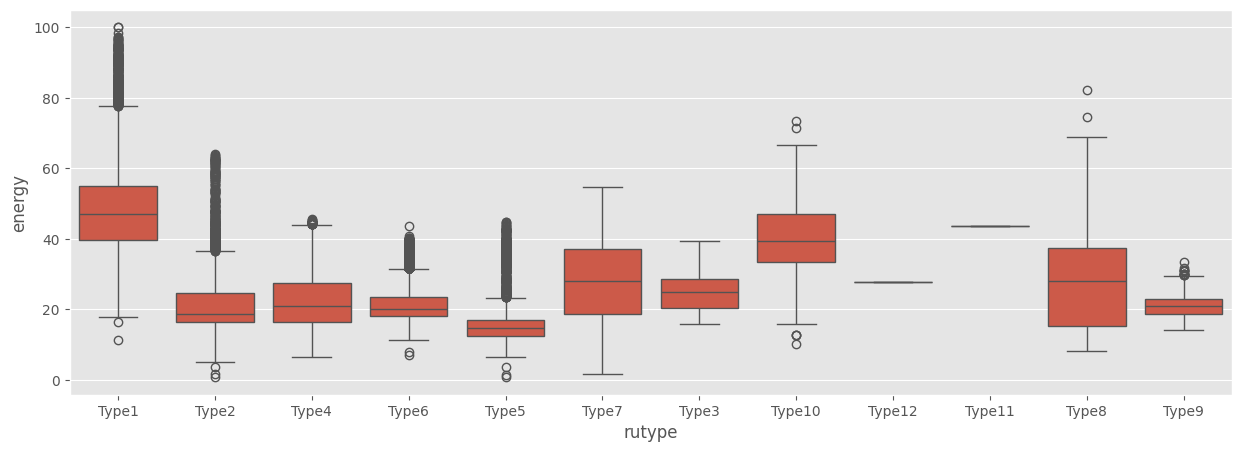

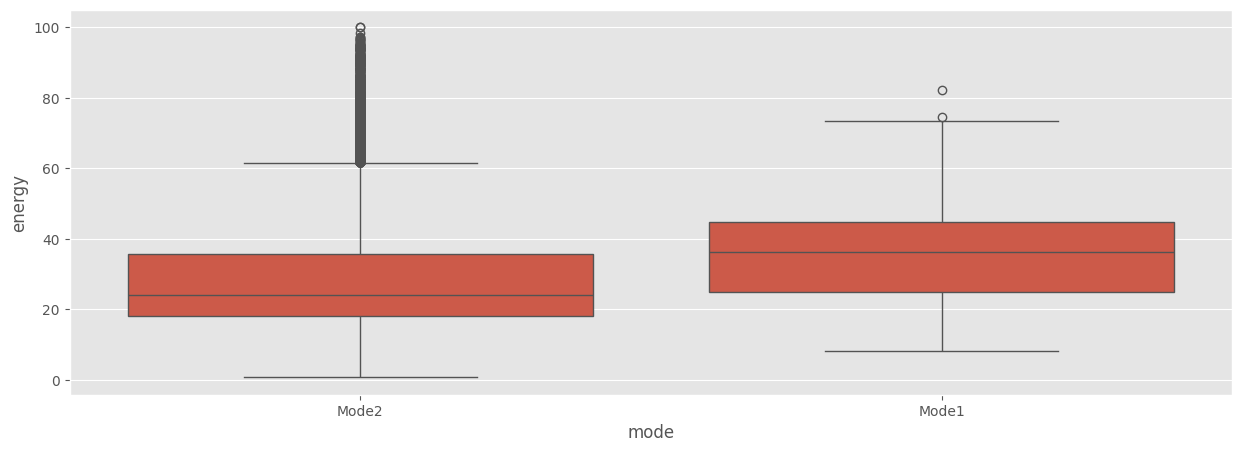

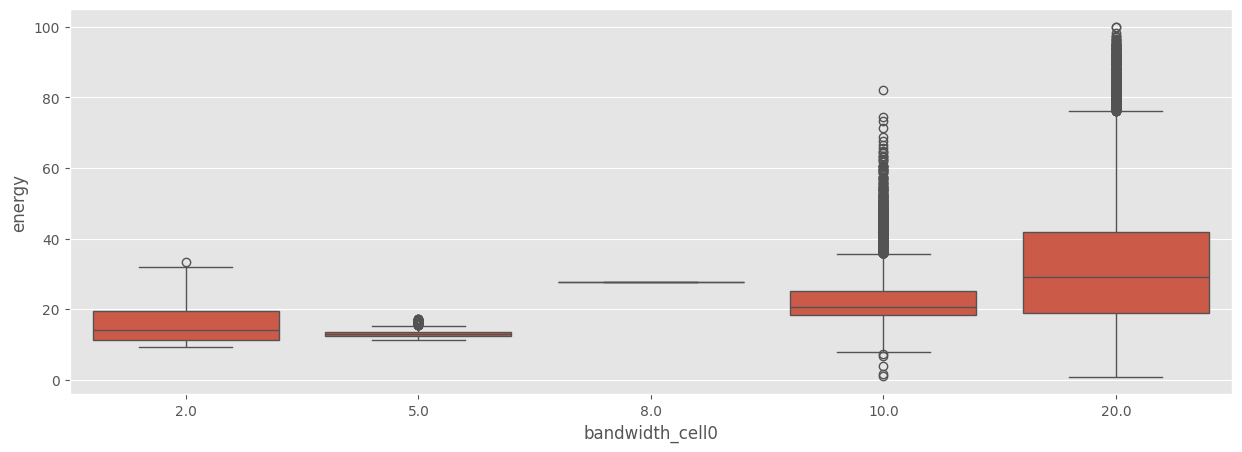

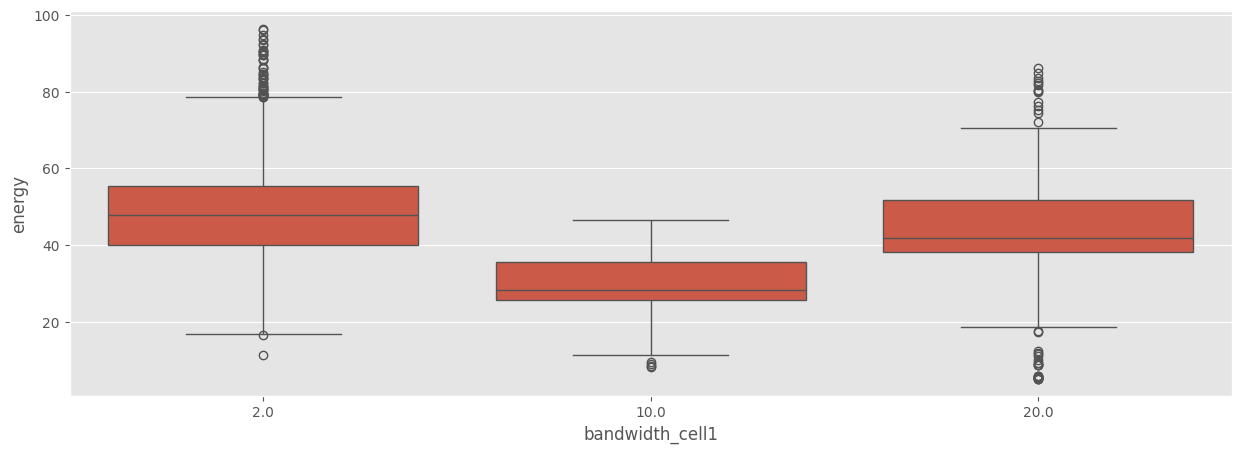

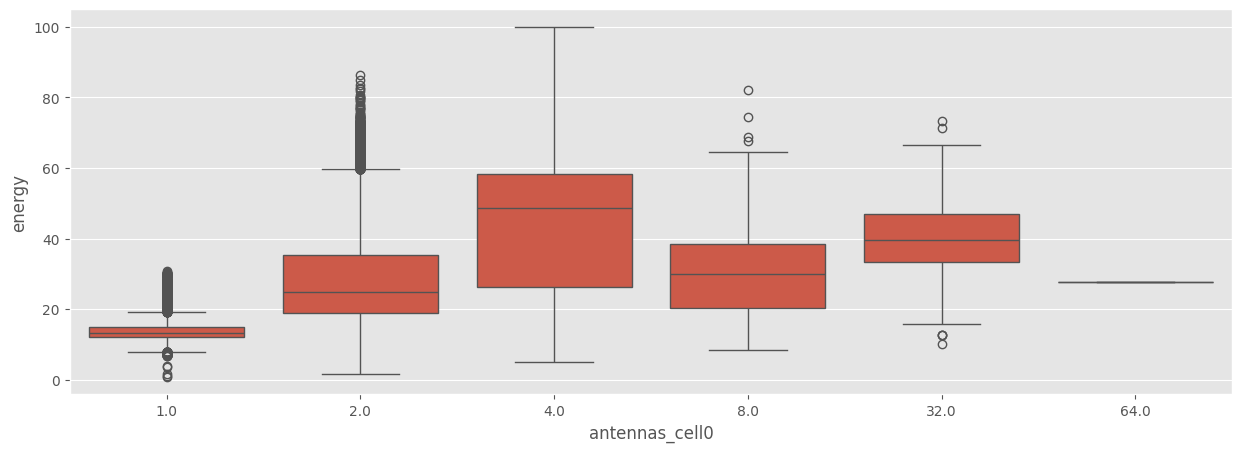

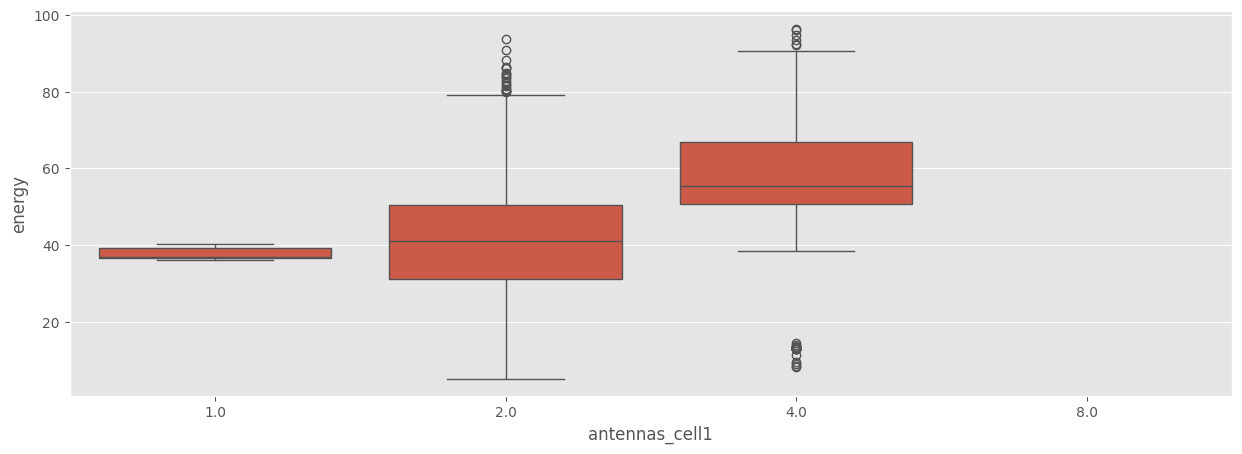

In [38]:
for feature in ['rutype','mode','bandwidth_cell0','bandwidth_cell1','antennas_cell0','antennas_cell1']:
    plt.figure(figsize=(15,5))
    sns.boxplot(data=df,x=feature,y='energy')
    plt.show()

From the box plots, we can analyze that the products of the following types consumes more energy

rutype - type1

Mode - Mode1

Bandwidth_cell0 - high bandwidth of 20 consumes more energy

Bandwidth_cell1 - bandwidths of 2 and 20 consumes almost same energy

Antennas_cell0 - increase in no of antennas consumes more energy. for this cell 4 antennas are taking high energy

Antennas_cell1 - increase in no of antennas consumes more energy. for this cell 4 antennas are taking high energy


Plotting the amount of  data present in the train and test dataset

Splitting and Merging the Data

In [39]:
pd.isna(df['energy']).value_counts()

,count
energy,
False,92629
True,26139


In [40]:
df['split'] = df['energy'].apply(lambda x: 'train' if pd.notna(x) else 'test')


In [41]:
def plot_cat_train_test_dist(df,feature,hue='split'):
    fig,axes = plt.subplots(1,3,figsize=(20,5))

    # Plot the distribution of training data on first plot
    sns.countplot(data=df[ df['split'] == 'train' ],ax=axes[0],x=feature)
    axes[0].set_title("Train Count Plot")

    # Plot the distribution of test data on first plot
    sns.countplot(data=df[ df['split'] == 'test' ],ax=axes[1],x=feature)
    axes[1].set_title("Test Count Plot")

    # Plot the distribution of training data on first plot
    sns.countplot(data=df,ax=axes[2],x=feature,hue='split')
    axes[2].set_title("Train & Test Count Plot")

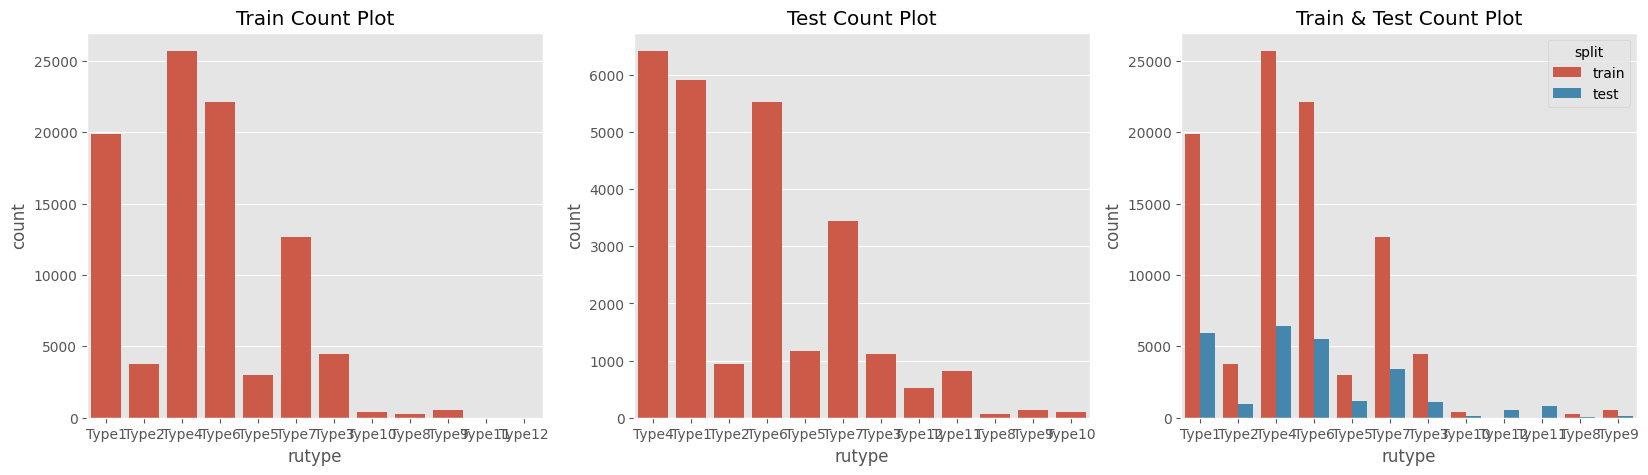

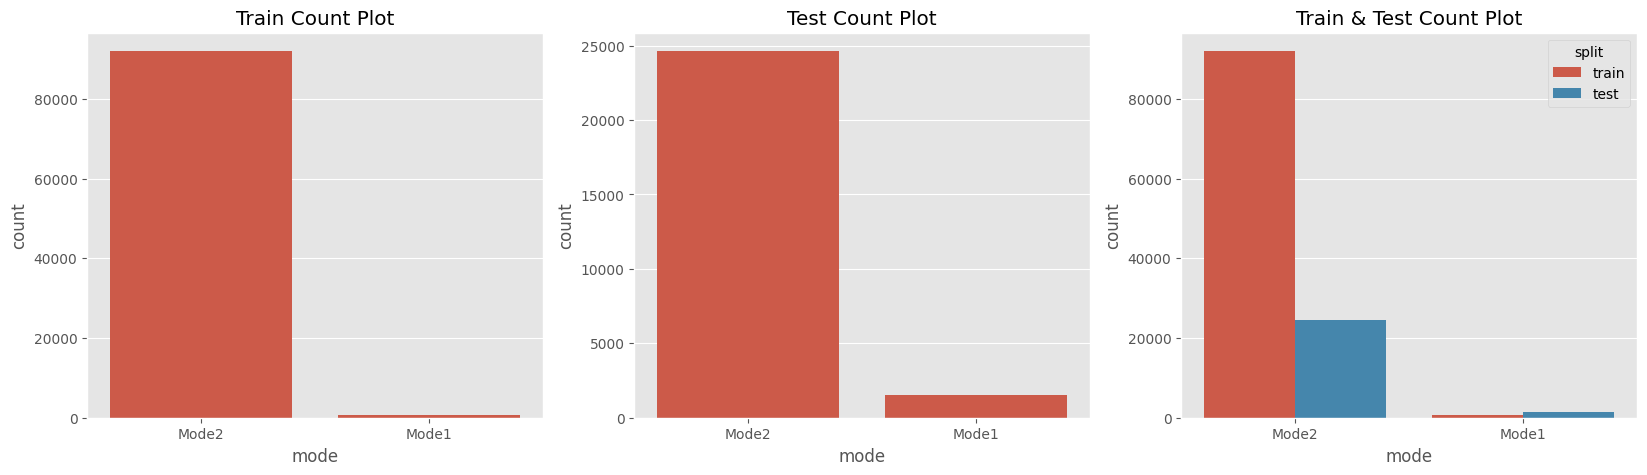

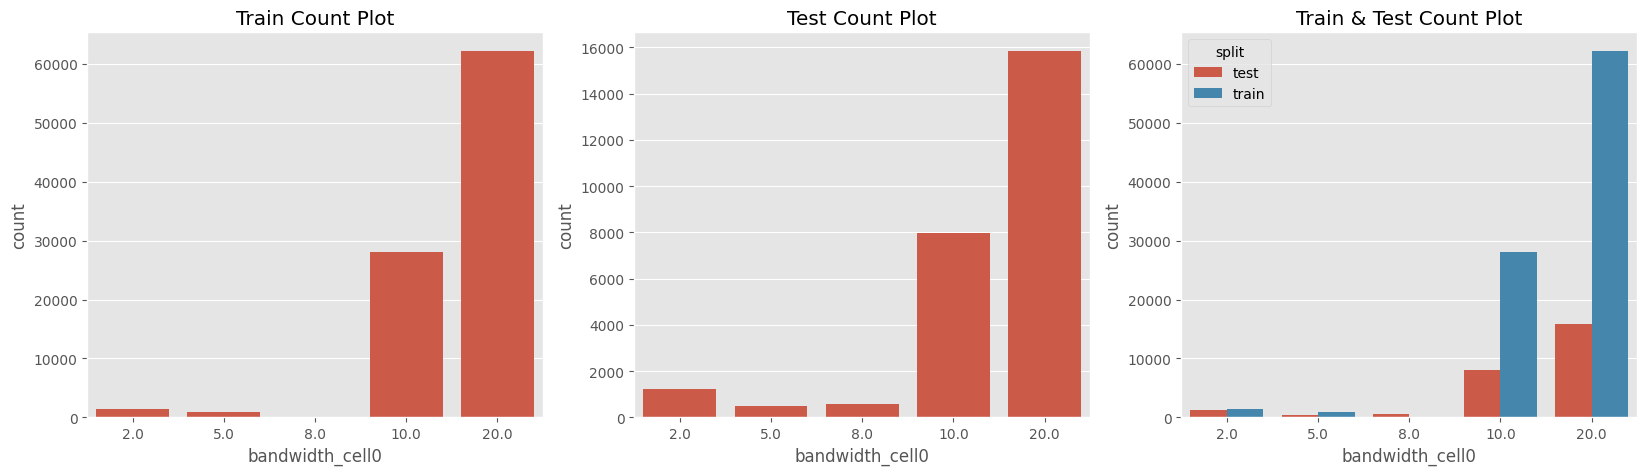

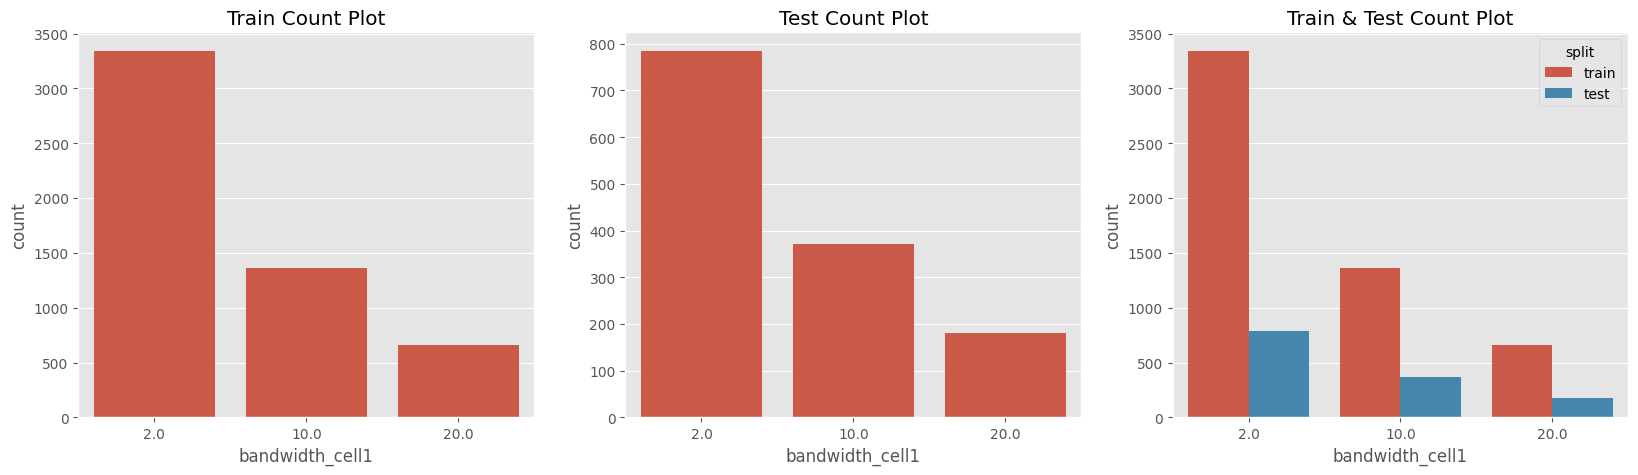

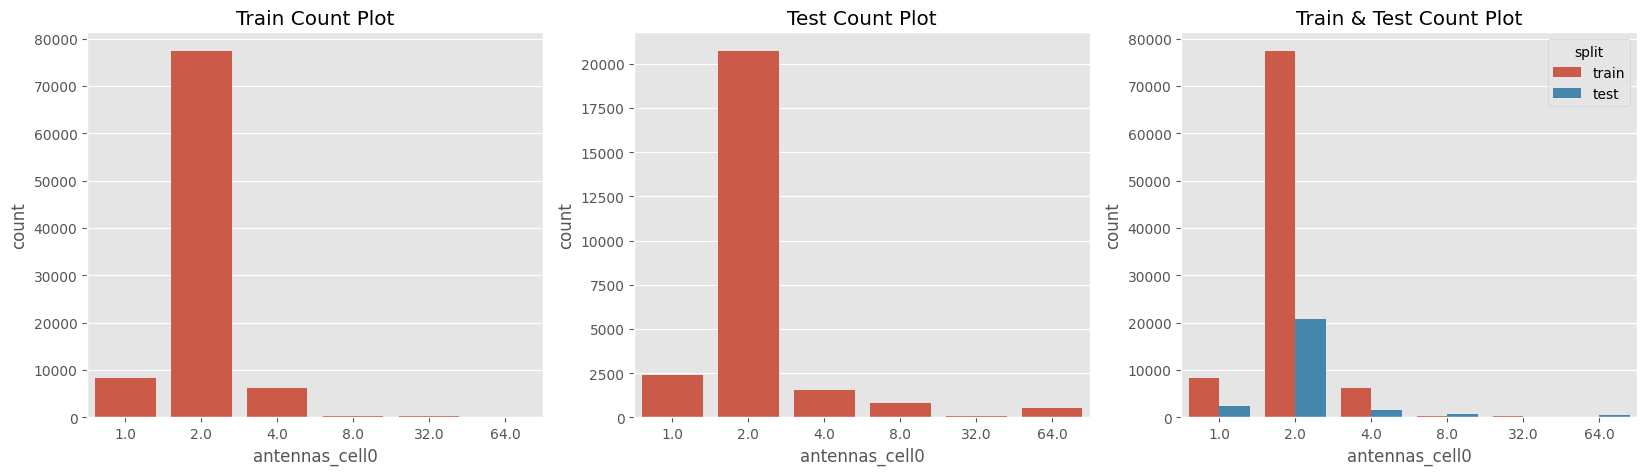

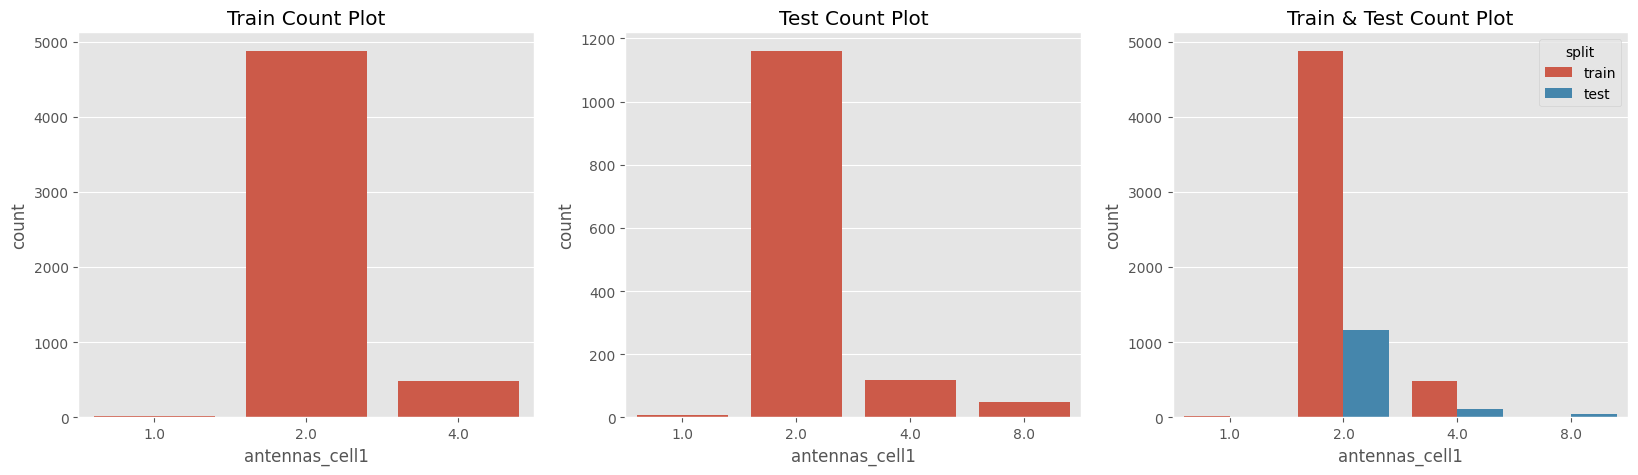

In [42]:
for feature in ['rutype','mode','bandwidth_cell0','bandwidth_cell1','antennas_cell0','antennas_cell1']:
    plot_cat_train_test_dist(df=df,feature = feature,hue='split')

In [43]:
df.groupby("split")['rutype'].value_counts().sort_index()

split  rutype
test   Type1      5908
       Type10      101
       Type11      815
       Type12      527
       Type2       939
       Type3      1111
       Type4      6419
       Type5      1164
       Type6      5521
       Type7      3446
       Type8        58
       Type9       130
train  Type1     19902
       Type10      403
       Type11        1
       Type12        1
       Type2      3757
       Type3      4442
       Type4     25677
       Type5      2974
       Type6     22083
       Type7     12641
       Type8       230
       Type9       518
Name: count, dtype: int64

Scatter plot between load and energy

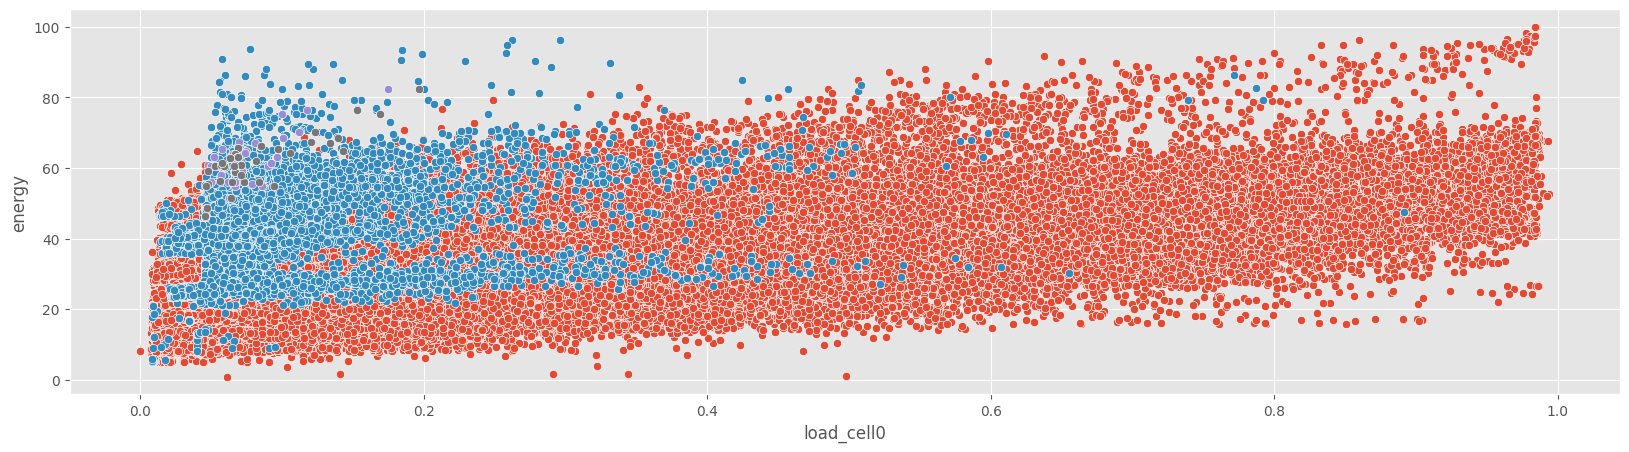

In [45]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=df[ df['split'] == 'train' ],x='load_cell0',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='load_cell1',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='load_cell2',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='load_cell3',y='energy')
plt.show()

Scatter plot between txpower and energy

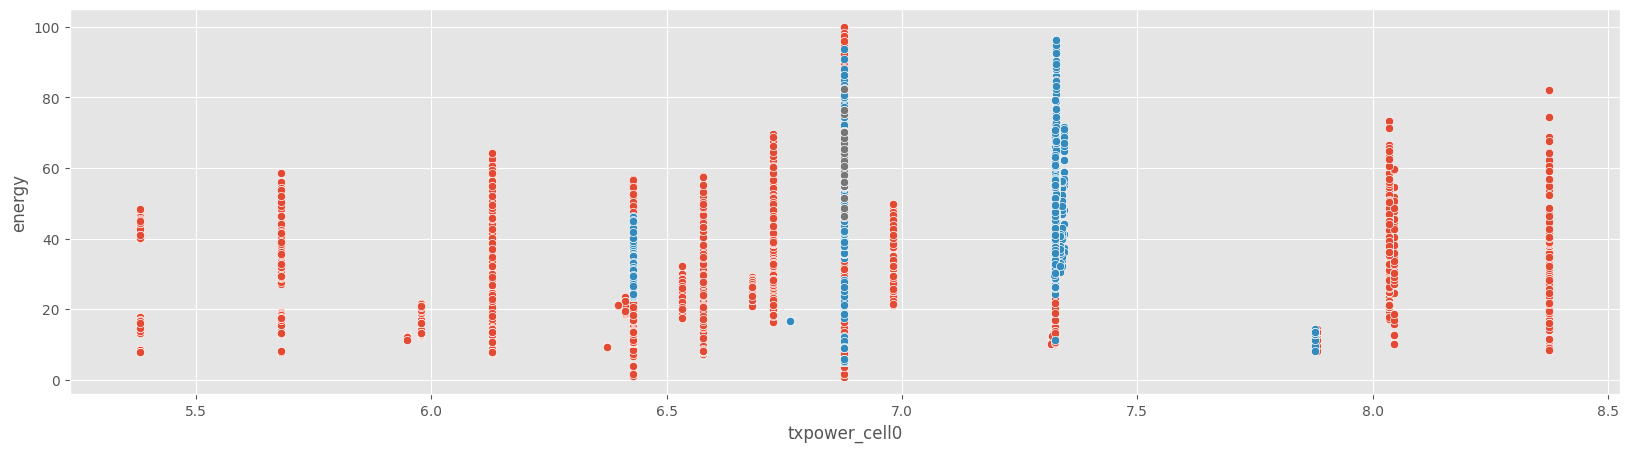

In [46]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=df[ df['split'] == 'train' ],x='txpower_cell0',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='txpower_cell1',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='txpower_cell2',y='energy')
sns.scatterplot(data=df[ df['split'] == 'train' ],x='txpower_cell3',y='energy')
plt.show()

Some feature values are present in train data and not present in test data. viceversa.

## Modelling

In [47]:
train_data = df[ df['split'] == "train" ]
test_data = df[ df['split']  == 'test' ]

train_data.shape , test_data.shape

((92629, 50), (26139, 50))

In [57]:
def feature_engineering( train_df , valid_df , test_df ):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df,valid_df,test_df])
    df['bs_en'] = df['bs'].apply( lambda x: int(x.strip("B_")))

    df = pd.get_dummies(df , columns=['rutype','mode','hour'])

    df.sort_values(['time','bs'],inplace=True)

    train_df = df[ df['split'] == 'train' ]
    valid_df = df[ df['split'] == 'valid' ]
    test_df = df[ df['split'] == 'test' ]

    return train_df , valid_df , test_df

In [58]:
target_col = 'energy'
drop_cols = ['time','bs','split',target_col]

In [59]:
kf = model_selection.KFold(n_splits=5)
kf = kf.split(X=train_data)

oof_valid_preds = np.zeros(train_data.shape[0],)
test_preds_list = []

for i , (train_idx , valid_idx) in enumerate(kf):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df , valid_df , test_df = feature_engineering(
                                        train_df = train_df,
                                        valid_df = valid_df,
                                        test_df = test_df
                                    )
    train_cols = [ col for col in train_df.columns if col not in drop_cols ]

    x_train , y_train = train_df[train_cols] , train_df[target_col]
    x_valid , y_valid = valid_df[train_cols] , valid_df[target_col]
    x_test = test_df[train_cols]

    params = {
        'objective' : 'regression',
        'boosting_type' : 'gbdt',
        # 'learning_rate': 0.01,
        'n_jobs' : -1,
        'max_depth' : -1,
        'metric' : 'mae',
        'num_boost_round' : 10000,
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(
        100,
        first_metric_only=True,
        verbose = False
    )
    verbose_callback = lgb.log_evaluation(100)

    model.fit(
        x_train , y_train,
        eval_set = [(x_valid , y_valid)],
        callbacks=[early_stopping_callback,verbose_callback]
    )

    valid_preds = model.predict(x_valid)
    test_preds = model.predict(x_test)

    val_score = metrics.mean_absolute_error(y_valid , valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("-"*50)
    print(f"Fold : {i}")
    print(f"Valid score : ",val_score)

oof_score = metrics.mean_absolute_error(train_data[target_col],oof_valid_preds)
print("_"*50)
print("OOF score : ",oof_score)

<ipython-input-57-c8869df98cbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2019
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 79
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.313705
[100]	valid_0's l1: 2.05555
[200]	valid_0's l1: 1.85915
[300]	valid_0's l1: 1.76632
[400]	valid_0's l1: 1.69355
[500]	valid_0's l1: 1.63654
[600]	valid_0's l1: 1.59842
[700]	valid_0's l1: 1.56794
[800]	valid_0's l1: 1.54407
[900]	valid_0's l1: 1.52814
[1000]	valid_0's l1: 1.51438
[1100]	valid_0's l1: 1.50058
[1200]	valid_0's l1: 1.49275
[1300]	valid_0's l1: 1.48477
[1400]	valid_0's l1: 1.47815
[1500]	val

<ipython-input-57-c8869df98cbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1707
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 57
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.276547
[100]	valid_0's l1: 1.97023
[200]	valid_0's l1: 1.76464
[300]	valid_0's l1: 1.6741
[400]	valid_0's l1: 1.59956
[500]	valid_0's l1: 1.55691
[600]	valid_0's l1: 1.53256
[700]	valid_0's l1: 1.51361
[800]	valid_0's l1: 1.49339
[900]	valid_0's l1: 1.47712
[1000]	valid_0's l1: 1.46774
[1100]	valid_0's l1: 1.46058
[1200]	valid_0's l1: 1.45593
[1300

<ipython-input-57-c8869df98cbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 79
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.059540
[100]	valid_0's l1: 2.04111
[200]	valid_0's l1: 1.86153
[300]	valid_0's l1: 1.76934
[400]	valid_0's l1: 1.70779
[500]	valid_0's l1: 1.66535
[600]	valid_0's l1: 1.63693
[700]	valid_0's l1: 1.61758
[800]	valid_0's l1: 1.5997
[900]	valid_0's l1: 1.58723
[1000]	valid_0's l1: 1.57652
[1100]	valid_0's l1: 1.56683
[1200]	valid_0's l1: 1.55931
[1300

<ipython-input-57-c8869df98cbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2034
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 79
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 27.913267
[100]	valid_0's l1: 1.99207
[200]	valid_0's l1: 1.78169
[300]	valid_0's l1: 1.68927
[400]	valid_0's l1: 1.62739
[500]	valid_0's l1: 1.58037
[600]	valid_0's l1: 1.54186
[700]	valid_0's l1: 1.51917
[800]	valid_0's l1: 1.49964
[900]	valid_0's l1: 1.48399
[1000]	valid_0's l1: 1.47006
[1100]	valid_0's l1: 1.45698
[1200]	valid_0's l1: 1.44573
[130

<ipython-input-57-c8869df98cbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['hour'] = train_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['hour'] = valid_df['time'].dt.hour
<ipython-input-57-c8869df98cbf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1980
[LightGBM] [Info] Number of data points in the train set: 74104, number of used features: 78
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.131925
[100]	valid_0's l1: 2.01174
[200]	valid_0's l1: 1.82615
[300]	valid_0's l1: 1.73993
[400]	valid_0's l1: 1.67534
[500]	valid_0's l1: 1.63237
[600]	valid_0's l1: 1.60503
[700]	valid_0's l1: 1.58158
[800]	valid_0's l1: 1.56026
[900]	valid_0's l1: 1.54642
[1000]	valid_0's l1: 1.5309
[1100]	valid_0's l1: 1.52105
[1200]	valid_0's l1: 1.51134
[1300

In [60]:
test_preds_list

[array([15.43070238, 46.30730906, 19.22536472, ..., 19.16077274,
        20.12503039, 37.38867166]),
 array([16.29839829, 47.64572212, 18.25227204, ..., 18.85286516,
        20.91558253, 37.42780025]),
 array([15.70159102, 46.70625555, 18.54344248, ..., 18.42522982,
        20.44719378, 37.11533815]),
 array([16.20969123, 46.1642308 , 18.72173563, ..., 18.53151024,
        20.44104586, 37.05793505]),
 array([15.22810705, 47.31505769, 18.08830937, ..., 18.33827922,
        20.57796283, 37.20023528])]

In [61]:
test_preds_mean = np.mean(test_preds_list , axis=0)

In [64]:
# Mean of 5 k fold test predictions
test_preds_mean

array([15.77369799, 46.82771504, 18.56622485, ..., 18.66173144,
       20.50136308, 37.23799608])

In [65]:
test_preds_mean.shape

(26139,)

In [66]:
test_data.shape

(26139, 50)

In [67]:
test_data.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy,split
3,2023-01-01 01:00:00,B_100,0.01122,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN,test
8,2023-01-01 01:00:00,B_105,0.05030,0.01674,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,365.0,365.0,NaN,NaN,20.0,20.0,NaN,NaN,2.0,2.0,NaN,NaN,6.875934,6.875934,NaN,NaN,Type1,Mode2,NaN,test
10,2023-01-01 01:00:00,B_107,0.49716,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.128550,NaN,NaN,NaN,Type4,Mode2,NaN,test
15,2023-01-01 01:00:00,B_111,0.37218,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.128550,NaN,NaN,NaN,Type1,Mode2,NaN,test
18,2023-01-01 01:00:00,B_114,0.46663,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,NaN,test


In [68]:
# Adding the predicted test values to test dataset
test_data['Energy'] = test_preds_mean

<ipython-input-68-685b99595032>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Energy'] = test_preds_mean


<Axes: >

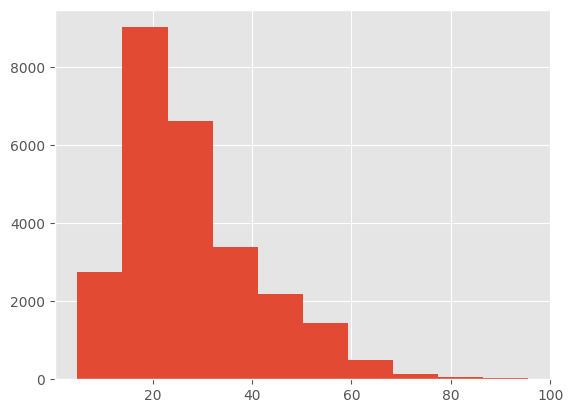

In [70]:
# Train and test data seems to have same distribution
test_data['Energy'].hist()

## Creating output format

In [73]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

<ipython-input-73-2d714949cf36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']


In [74]:
test_data[['ID','Energy']]

,ID,Energy
3,2023-01-01 01:00:00_B_100,15.773698
8,2023-01-01 01:00:00_B_105,46.827715
10,2023-01-01 01:00:00_B_107,18.566225
15,2023-01-01 01:00:00_B_111,34.288705
18,2023-01-01 01:00:00_B_114,24.332797
...,...,...
118757,2023-01-08 00:00:00_B_786,26.459958
118761,2023-01-08 00:00:00_B_790,20.751127
118762,2023-01-08 00:00:00_B_791,18.661731
118763,2023-01-08 00:00:00_B_792,20.501363


In [75]:
ss_df = test_data[['ID']]

In [76]:
ss_df = ss_df.merge(test_data[['ID','Energy']],on='ID',how='left')

In [77]:
ss_df.head()

,ID,Energy
0,2023-01-01 01:00:00_B_100,15.773698
1,2023-01-01 01:00:00_B_105,46.827715
2,2023-01-01 01:00:00_B_107,18.566225
3,2023-01-01 01:00:00_B_111,34.288705
4,2023-01-01 01:00:00_B_114,24.332797


In [81]:
ss_df.to_csv("power_consumption_estimation.csv",index=False)